<a href="https://colab.research.google.com/github/MoohShadox/MCNN_Training/blob/main/Seance_02_Apprentissage_supervis%C3%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import os
import numpy as np
import pandas as pd
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch 
import cv2
import re
from torchvision import datasets, models, transforms
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.datase11664

# Au menu : Des architectures plus deep

---

Aujourd'hui on va aborder différentes aspects liés a l'apprentissage supervisé, on va d'abord introduire la classification et montrer comment on peut en faire en utilisant un réseau de neurones, on commençera par un cas simple puis on présentera un cas avec des images ou nous étudierons l'utilisation des convolutions dans ce cadre la.

Ensuite on va reparler de regression et nous profiterons du fait de l'avoir déja présenté pour introduire les LSTM et les appliquer a un problème de regression.

# Introduction a la classification


---


La classification c'est une branche de l'apprentissage supervisé ou la décision a prendre est une décision d'appartenance ou non a une ou plusieurs classes.

La ou une regression répond a la question "combien de Y ?" la classification répond a la question "Y ou pas Y" dans le cas d'une classification binaire, et a la question "Quel Y ?" dans le cas d'une classification avec plusieurs étiquettes.

A noter que les deux catégories ne s'excluent pas mutuellement, le problème précédent de détermination de la qualité du vin aurait tout aussi bien pu être résolu par classification (et d'ailleurs on le fera plus tard pour voire ce qui marche le mieux) 


## Le traditionnel exemple jouet


In [75]:
#Une liste de coordonnées
X = np.random.random((10,2))
X.shape

(10, 2)

In [76]:
frontiere = np.array([3,5]).reshape((-1,1))
frontiere.shape

(2, 1)

In [77]:
(X@frontiere - 4).T

array([[ 0.09217735, -1.69566   , -0.58301549, -0.87156382,  0.5910684 ,
        -2.58892732, -0.75152172, -0.36949153, -0.78090918, -0.35756058]])

In [78]:
y = np.where(X@frontiere - 4 > 0, 1, 0)
y.T

array([[1, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

In [79]:
def classify(X):
  return np.where(X@frontiere - 4 > 0, 1, 0).reshape((-1,))


def plot_dec_boundary(predict_proba):
  X = np.random.random((500,2)) 
  y = classify(X)
  xx, yy = np.mgrid[-0:1:.01, -0:1:.01]
  grid = np.c_[xx.ravel(), yy.ravel()]
  probs = predict_proba(grid).reshape(xx.shape)
  f, ax = plt.subplots(figsize=(8, 6))

  contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                        vmin=0, vmax=1)
  
  ax_c = f.colorbar(contour)
  ax_c.set_label("$P(y = 1)$")
  ax_c.set_ticks([0, .25, .5, .75, 1])
  print(X.shape)
  print(y.shape)
  ax.scatter(X[:,0],X[:,1],c = y, cmap="RdBu",edgecolor="white", linewidth=1)

(500, 2)
(500,)


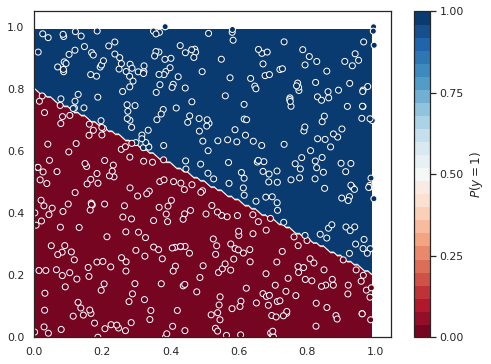

In [80]:
plot_dec_boundary(classify)

## Cas monoclasse

De la même façon qu'un réseau de neurones a une seule couche peut faire de la regression il peut faire de la regression logistique.

La regression logistique consiste en une regression qui prédit une sigmoid, la fonction sigmoid est une fonction qui renvoie toujours quelque chose entre 0 et 1 et donc c'est un peu comme si on essayait de prédire la probabilité d'apparentance a une des deux classes.

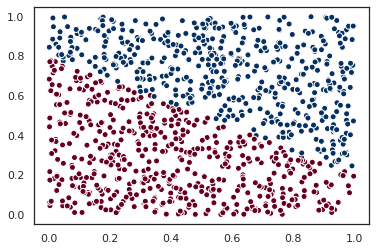

In [59]:
#Rappel voici nos points avec une belle frontière bien linéaire au milieu
plt.scatter(X[:,0],X[:,1],c = y, cmap="RdBu",edgecolor="white", linewidth=1)

In [89]:
class LogisticRegression(nn.Module):
  def __init__(self, n_in):
    super().__init__()
    self.l1 = nn.Linear(n_in, 1,bias = True)
    self.sigm = nn.Sigmoid()
  
  def forward(self, x):
    x = self.l1(x)
    return self.sigm(x)
  

In [173]:
X = np.random.random((10000,2))
y = np.where(X@frontiere - 4 > 0, 1, 0)

In [174]:
L = LogisticRegression(2)
X_tensor = torch.tensor(X).float()
L(X_tensor)

tensor([[0.4956],
        [0.5597],
        [0.5780],
        ...,
        [0.4913],
        [0.4617],
        [0.5277]], grad_fn=<SigmoidBackward>)

In [175]:
y_tensor = torch.tensor(y).float().view((-1,))
y_tensor.shape

torch.Size([10000])

In [182]:
L = LogisticRegression(2)
criterion = torch.nn.BCELoss(reduction="mean")
optimizer = torch.optim.SGD(L.parameters(), lr=5e-1)
for i in range(20000):
  pred = L(X_tensor).view((-1,))
  loss = criterion(pred,y_tensor)
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()
print(loss)

tensor(0.0576, grad_fn=<BinaryCrossEntropyBackward>)


(1000, 2)
(1000, 1)


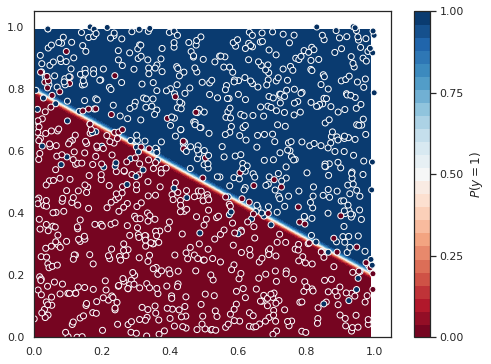

In [205]:

def plot_dec_boundary(predict_proba,X,y):
  xx, yy = np.mgrid[-0:1:.01, -0:1:.01]
  grid = np.c_[xx.ravel(), yy.ravel()]
  grid = torch.tensor(grid).float()
  probs = predict_proba(grid).reshape(xx.shape)
  f, ax = plt.subplots(figsize=(8, 6))

  contour = ax.contourf(xx, yy, probs.detach().numpy(), 25, cmap="RdBu",
                        vmin=0, vmax=1)
  
  ax_c = f.colorbar(contour)
  ax_c.set_label("$P(y = 1)$")
  ax_c.set_ticks([0, .25, .5, .75, 1])
  print(X.shape)
  print(y.shape)
  ax.scatter(X[:,0],X[:,1],c = y, cmap="RdBu",edgecolor="white", linewidth=1)

plot_dec_boundary(L,X,y)

In [185]:
y[0:10]

array([[0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1]])

In [217]:
class DeepLogisticRegression(nn.Module):
  def __init__(self, n_in):
    super().__init__()
    self.relu = nn.ReLU()
    self.l1 = nn.Linear(n_in, 15,bias = True)
    self.l2 = nn.Linear(15,1)
    self.sigm = nn.Sigmoid()
  
  def forward(self, x):
    x = self.l1(x)
    x = self.relu(x)
    x = self.l2(x)
    return self.sigm(x)

accuracy_l = []
loss_l = []
L = DeepLogisticRegression(2)
criterion = torch.nn.BCELoss(reduction="mean")
optimizer = torch.optim.SGD(L.parameters(), lr=5e-1)
for i in range(20000):
  pred = L(X_tensor).view((-1,))
  loss = criterion(pred,y_tensor)
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  accuracy = (pred > .5) == y_tensor
  accuracy_l.append(accuracy.detach().numpy().astype(int).mean())
  loss_l.append(loss.detach().numpy())

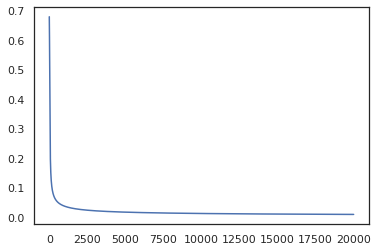

In [221]:
plt.plot(np.arange(len(loss_l)),loss_l)

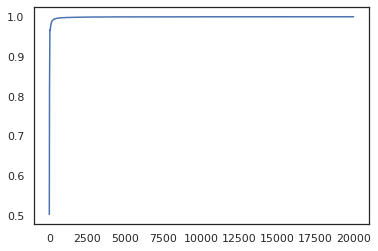

In [222]:
plt.plot(np.arange(len(accuracy_l)),accuracy_l)

## Cas réel : Classification d'images

Enfin, nous pouvons manipuler un vrai dataset, avec des vraies images

J'ai essayé de choisir l'exemple le moins "tutoriel" possible pour qu'on puisse se heurter a toute la problématique liée a la forme du dataset.

Ici le dataset a été trouvé sur cette [page](https://data.mendeley.com/datasets/4drtyfjtfy/1), j'ai copié le lien, j'ai utilisé wget et ensuite j'ai unzip successivement ce qu'il y avais a l'intérieur. 

In [6]:
!wget https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/4drtyfjtfy-1.zip

--2020-12-30 20:42:52--  https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/4drtyfjtfy-1.zip
Resolving md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)... 52.218.54.11
Connecting to md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)|52.218.54.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 95592747 (91M) [application/octet-stream]
Saving to: ‘4drtyfjtfy-1.zip’

4drtyfjtfy-1.zip    100%[===================>]  91.16M  49.9MB/s    in 1.8s    

2020-12-30 20:42:54 (49.9 MB/s) - ‘4drtyfjtfy-1.zip’ saved [95592747/95592747]



In [8]:
!unzip 4drtyfjtfy-1.zip

Archive:  4drtyfjtfy-1.zip
  inflating: dataset2.zip            


In [10]:
!unzip dataset2.zip

Archive:  dataset2.zip
   creating: dataset2/
  inflating: dataset2/cloudy1.jpg    
  inflating: dataset2/cloudy10.jpg   
  inflating: dataset2/cloudy100.jpg  
  inflating: dataset2/cloudy101.jpg  
  inflating: dataset2/cloudy102.jpg  
  inflating: dataset2/cloudy103.jpg  
  inflating: dataset2/cloudy104.jpg  
  inflating: dataset2/cloudy105.jpg  
  inflating: dataset2/cloudy106.jpg  
  inflating: dataset2/cloudy107.jpg  
  inflating: dataset2/cloudy108.jpg  
  inflating: dataset2/cloudy109.jpg  
  inflating: dataset2/cloudy11.jpg   
  inflating: dataset2/cloudy110.jpg  
  inflating: dataset2/cloudy111.jpg  
  inflating: dataset2/cloudy112.jpg  
  inflating: dataset2/cloudy113.jpg  
  inflating: dataset2/cloudy114.jpg  
  inflating: dataset2/cloudy115.jpg  
  inflating: dataset2/cloudy116.jpg  
  inflating: dataset2/cloudy117.jpg  
  inflating: dataset2/cloudy118.jpg  
  inflating: dataset2/cloudy119.jpg  
  inflating: dataset2/cloudy12.jpg   
  inflating: dataset2/cloudy120.jpg  
  in

In [3]:
!ls dataset2

cloudy100.jpg  cloudy32.jpg  rain42.jpg    shine247.jpg    sunrise221.jpg
cloudy101.jpg  cloudy33.jpg  rain43.jpg    shine248.jpg    sunrise222.jpg
cloudy102.jpg  cloudy34.jpg  rain44.jpg    shine249.jpg    sunrise223.jpg
cloudy103.jpg  cloudy35.jpg  rain45.jpg    shine24.jpg	   sunrise224.jpg
cloudy104.jpg  cloudy36.jpg  rain46.jpg    shine250.jpg    sunrise225.jpg
cloudy105.jpg  cloudy37.jpg  rain47.jpg    shine251.jpg    sunrise226.jpg
cloudy106.jpg  cloudy38.jpg  rain48.jpg    shine252.jpg    sunrise227.jpg
cloudy107.jpg  cloudy39.jpg  rain49.jpg    shine253.jpg    sunrise228.jpg
cloudy108.jpg  cloudy3.jpg   rain4.jpg	   shine25.jpg	   sunrise229.jpg
cloudy109.jpg  cloudy40.jpg  rain50.jpg    shine26.jpg	   sunrise22.jpg
cloudy10.jpg   cloudy41.jpg  rain51.jpg    shine27.jpg	   sunrise230.jpg
cloudy110.jpg  cloudy42.jpg  rain52.jpg    shine28.jpg	   sunrise231.jpg
cloudy111.jpg  cloudy43.jpg  rain53.jpg    shine29.jpg	   sunrise232.jpg
cloudy112.jpg  cloudy44.jpg  rain54.jpg    shi

Maintenant nous allons construire notre objet Dataset manuellement car la forme du fichier est assez spécifique.

In [7]:
import os
import cv2 
import re

class Wheather_Dataset(Dataset):
    """Face Landmarks dataset."""

    class_index = ["cloudy", "rain", "shine", "sunrise"]

    def __init__(self, root_dir, transform=None):
        self.dirs = os.listdir(root_dir)
        self.root_dir = root_dir
        self.transform = transform


    def __len__(self):
        return len(self.dirs)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,self.dirs[idx])

        image = cv2.imread(img_name)

        classe = re.findall(r"(\D+)",self.dirs[idx])[0]

        if self.transform:
            image = self.transform(image)
        
        sample = {'image': image, 'landmarks': Wheather_Dataset.class_index.index(classe)}

        return sample

In [8]:
dataset = Wheather_Dataset("dataset2")

In [9]:
#On vérifie qu'on peut bien en parcourir quelques samples 
for i in range(len(dataset)):
    sample = dataset[i]
    print(i, sample['image'].shape, sample['landmarks'])
    if i == 3:
        break

0 (168, 299, 3) 2
1 (1360, 2048, 3) 1
2 (1200, 1600, 3) 3
3 (458, 608, 3) 2


Le grand soucis c'est que les images ont pas la même shape mais heureusement l'attribut transform nous permet d'y remedier facilement.

In [13]:
import torch 
from torchvision import datasets, models, transforms

trf = transforms.Compose([
        transforms.Resize((256)),
    ])
#Cette transformation très simple va Baisser la résolution des images a (224,224)

In [11]:
dataset = Wheather_Dataset("dataset2", transform=trf)
for i in range(len(dataset)):
    sample = dataset[i]
    print(i, sample['image'].shape, sample['landmarks'])
    if i == 3:
        break

TypeError: ignored

In [12]:
trf = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((256,256)),
    ]) #Faut d'abord convertir en Image PIL
dataset = Wheather_Dataset("dataset2", transform=trf)


0 <PIL.Image.Image image mode=RGB size=256x256 at 0x7F665C5DEF60> 2
(256, 256, 3)
1 <PIL.Image.Image image mode=RGB size=256x256 at 0x7F6652930710> 1
(256, 256, 3)
2 <PIL.Image.Image image mode=RGB size=256x256 at 0x7F6652930A58> 3
(256, 256, 3)
3 <PIL.Image.Image image mode=RGB size=256x256 at 0x7F6652930D68> 2


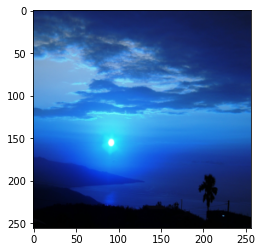

In [13]:
for i in range(len(dataset)):
    sample = dataset[i]
    print(i, sample['image'], sample['landmarks'])
    if i == 3:
        break
    pix = np.array(sample['image'])
    print(pix.shape)
    plt.imshow(pix)

In [14]:
trf = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((256,256)),
        transforms.ToTensor()
    ]) #Faut d'abord convertir en Image PIL
dataset = Wheather_Dataset("dataset2", transform=trf)

0 torch.Size([3, 256, 256]) 2
(3, 256, 256)
(256, 256, 3)
1 torch.Size([3, 256, 256]) 1
(3, 256, 256)
(256, 256, 3)
2 torch.Size([3, 256, 256]) 3
(3, 256, 256)
(256, 256, 3)
3 torch.Size([3, 256, 256]) 2


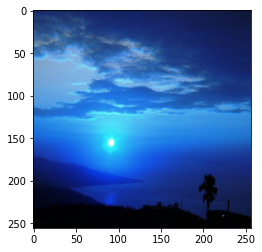

In [15]:
for i in range(len(dataset)):
    sample = dataset[i]
    print(i, sample['image'].shape, sample['landmarks'])
    if i == 3:
        break
    pix = sample["image"].numpy()
    print(pix.shape)
    pix = np.swapaxes(pix, 0,2)
    pix = np.swapaxes(pix, 1,0)
    print(pix.shape)
    plt.imshow(pix)

((256, 256, 3), 2)

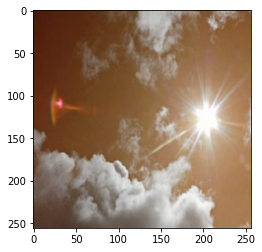

In [16]:
#On garde ça dans une fonction
def visualize(tensor_image):
    pix = tensor_image.numpy()
    pix = np.swapaxes(pix, 0,2)
    pix = np.swapaxes(pix, 1,0)
    plt.imshow(pix)
    return pix


visualize(sample["image"]).shape, sample["landmarks"]

In [12]:
import torch.nn as nn
import torch.nn.functional as F


class Image_Classifier(nn.Module):
    def __init__(self):
        super(Image_Classifier, self).__init__()
        self.fc1 = nn.Linear(256 * 256 * 3, 4)

    def forward(self, x):
      x = torch.flatten(x, start_dim=1)
      x = self.fc1(x)
      return x

dataset = Wheather_Dataset("dataset2", transform=trf)
testloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=False, num_workers=2)

NameError: ignored

In [16]:
for i in testloader:
  print(i["image"].shape)
  
  break

torch.Size([4, 3, 256, 256])


In [218]:

net = Image_Classifier()
for i in testloader:
  imgs = i["image"]
  p = net(imgs)
  print(p.shape)
  print(i["landmarks"].shape)
  break

torch.Size([4, 4])
torch.Size([4])


In [219]:
net = Image_Classifier()
criterion = nn.CrossEntropyLoss()
for i in testloader:
  imgs = i["image"] #Indice des vraies classes (4)
  p = net(imgs) #Probabilité [4] de chaque classe [4] donc [4,4]
  print(criterion(p, i["landmarks"]))
  break

tensor(1.3878, grad_fn=<NllLossBackward>)


In [220]:
net = Image_Classifier()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=5e-1)
for i in testloader:
  imgs = i["image"] #Indice des vraies classes (4)
  p = net(imgs) #Probabilité [4] de chaque classe [4] donc [4,4]
  loss = criterion(p, i["landmarks"])
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()
print(loss)

TypeError: ignored

Apparemment y'a un souci avec une image, je vais pas conséquent ajouter un mécanisme d'exception.


In [10]:

class Wheather_Dataset(Dataset):
    """Face Landmarks dataset."""

    class_index = ["cloudy", "rain", "shine", "sunrise"]

    def __init__(self, root_dir, transform=None):
        self.dirs = os.listdir(root_dir)
        self.root_dir = root_dir
        self.transform = transform


    def __len__(self):
        return len(self.dirs)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,self.dirs[idx])

        image = cv2.imread(img_name)

        classe = re.findall(r"(\D+)",self.dirs[idx])[0]

        try:
          if self.transform:
              image = self.transform(image)
        except:
          print("ERREUR AVEC L'IMAGE : ",img_name)
          
        sample = {'image': image, 'landmarks': Wheather_Dataset.class_index.index(classe)}

        return sample

In [26]:
trf = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((256,256)),
        transforms.ToTensor()
    ]) #Faut d'abord convertir en Image PIL
dataset = Wheather_Dataset("dataset2", transform=trf)
testloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=False, num_workers=2)
net = Image_Classifier()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=5e-1)
for i in testloader:
  imgs = i["image"] #Indice des vraies classes (4)
  p = net(imgs) #Probabilité [4] de chaque classe [4] donc [4,4]
  loss = criterion(p, i["landmarks"])
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()
print(loss)

tensor(506.9284, grad_fn=<NllLossBackward>)


In [249]:
!rm "dataset2/rain141.jpg"
!rm "dataset2/shine131.jpg"

rm: cannot remove 'dataset2/rain141.jpg': No such file or directory
rm: cannot remove 'dataset2/shine131.jpg': No such file or directory


In [271]:
trf = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((256,256)),
        transforms.ToTensor()
    ]) #Faut d'abord convertir en Image PIL
dataset = Wheather_Dataset("dataset2", transform=trf)
testloader = torch.utils.data.DataLoader(dataset, batch_size=5, shuffle=False, num_workers=2)
net = Image_Classifier()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-1)
total, true = 0,0
for i in range(20):
  loss_s = 0
  total, true = 0,0
  for i in testloader:
    imgs = i["image"] #Indice des vraies classes (4)
    p = net(imgs) #Probabilité [4] de chaque classe [4] donc [4,4]
    loss = criterion(p, i["landmarks"])
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    loss_s += loss.item()
    _, predicted = torch.max(p,axis=1)
    true += ((predicted==i["landmarks"]).int().sum())
    total += p.shape[0]
  precision = true/total*100
  print("loss : ",loss_s)
  print(f"precision {precision} % on {total} samples")

loss :  2244511.473290801
precision 62.68922805786133 % on 1123 samples
loss :  2178765.807914734
precision 68.56633758544922 % on 1123 samples
loss :  2156082.7281341553
precision 70.79251861572266 % on 1123 samples
loss :  1668165.4634056091
precision 73.46393585205078 % on 1123 samples
loss :  1998035.7534103394
precision 73.99822235107422 % on 1123 samples
loss :  1537981.1115112305
precision 77.56011199951172 % on 1123 samples
loss :  1422921.706363678
precision 77.91629791259766 % on 1123 samples
loss :  1457203.481060028
precision 76.04630279541016 % on 1123 samples
loss :  1681952.521270752
precision 77.64915466308594 % on 1123 samples
loss :  1238042.578704834
precision 80.40961456298828 % on 1123 samples
loss :  1771754.8784713745
precision 77.38201141357422 % on 1123 samples
loss :  1450717.4197769165
precision 80.05342864990234 % on 1123 samples
loss :  1806810.0274915695
precision 78.89581298828125 % on 1123 samples
loss :  1207295.552947998
precision 81.92341613769531 % o

In [4]:
class Deep_Image_Classifier(nn.Module):
    def __init__(self):
        super(Deep_Image_Classifier, self).__init__()
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(256 * 256 * 3, 256 * 256 * 3)
        self.out = nn.Linear(256 * 256 * 3, 4)


    def forward(self, x):
      x = torch.flatten(x, start_dim=1)
      x = self.relu(self.fc1(x))
      return self.out(x)

In [ ]:
#Lancer ça si vous voulez voire la RAM d'un environnement Colab
#net = Deep_Image_Classifier()

#Convolutions : un outil pour détecter des motifs locaux

Le meilleur moyen de comprendre ce que ça fait c'est d'en tester quelques unes sur des images.

In [49]:
class Convolution(nn.Module):
    def __init__(self):
        super(Convolution, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels = 6, kernel_size = (10,10))


    def forward(self, x):
      return self.conv1(x)

In [54]:
dataset = Wheather_Dataset("dataset2", transform=trf)

testloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=False, num_workers=2)

it = iter(testloader)
im = next(it)["image"]
C = Convolution()
print(im.shape)
print(C(im).shape)
print([i.shape for i in C.parameters()])

torch.Size([10, 3, 256, 256])
torch.Size([10, 6, 247, 247])
[torch.Size([6, 3, 10, 10]), torch.Size([6])]


Pour faire bref, une convolution est un ensemble de filtres, ici on a 6 filtres chacun se compose de (nombre de channels in* longueur* largeur) poids + 1 biais.

Donc le tenseur passe de $(channel_{in}*W*H)$ a $(channel_{out}*(W-W_k+1)*(H-H_k+1))$

Pour comprendre exactement comme fonctionne une convolution cet article de (Parabu) est parfait : [Understanding of Convolutional Neural Network (CNN) — Deep Learning](https://medium.com/@RaghavPrabhu/understanding-of-convolutional-neural-network-cnn-deep-learning-99760835f148)

Généralement ce genre de layers sont utilisés aux coté de Pooling layer servant a réduire la dimension de l'image.

Testons en quelques uns.


In [61]:
class Convolution(nn.Module):
    def __init__(self):
        super(Convolution, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=(2,3))


    def forward(self, x):
      return self.pool(x)

In [62]:
dataset = Wheather_Dataset("dataset2", transform=trf)

testloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=False, num_workers=2)

it = iter(testloader)
im = next(it)["image"]
C = Convolution()
print(im.shape)
print(C(im).shape)
print([i.shape for i in C.parameters()])

torch.Size([10, 3, 256, 256])
torch.Size([10, 3, 128, 85])
[]


Donc la premier constat : aucun paramètre ne s'entraine, en revanche la diminution de la dimension n'est pas une soustraction mais une division par le kernel.

In [69]:
class Convolution(nn.Module):
    def __init__(self):
        super(Convolution, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels = 6, kernel_size = (4,4))
        self.pool1 = nn.MaxPool2d(kernel_size=(3,3))
        self.conv2 = nn.Conv2d(in_channels=6, out_channels = 12, kernel_size = (4,4))
        self.pool2 = nn.MaxPool2d(kernel_size=(3,3))


    def forward(self, x):
      x = self.conv1(x)
      x = self.pool1(x)
      x = self.conv2(x)
      x = self.pool2(x)
      return x

In [70]:
dataset = Wheather_Dataset("dataset2", transform=trf)

testloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=False, num_workers=2)

it = iter(testloader)
im = next(it)["image"]
C = Convolution()
print(im.shape)
print(C(im).shape)
print([i.shape for i in C.parameters()])

torch.Size([10, 3, 256, 256])
torch.Size([10, 12, 27, 27])
[torch.Size([6, 3, 4, 4]), torch.Size([6]), torch.Size([12, 6, 4, 4]), torch.Size([12])]


In [176]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(3, 3)
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.l2 = nn.Linear(11664,4)



    def forward(self, x):
      x = self.pool(F.relu(self.conv1(x)))
      x = self.pool(F.relu(self.conv2(x)))
      x = torch.flatten(x, start_dim=1)
      #print(x.shape)
      x = self.l2(x)
      return x

In [177]:
dataset = Wheather_Dataset("dataset2", transform=trf)

testloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=False, num_workers=2)

it = iter(testloader)
im = next(it)["image"]
C = CNN()
print(im.shape)
print(C(im).shape)

torch.Size([10, 3, 256, 256])
torch.Size([10, 4])


In [180]:
trf = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((256,256)),
        transforms.ToTensor()
    ]) #Faut d'abord convertir en Image PIL
dataset = Wheather_Dataset("dataset2", transform=trf)
testloader = torch.utils.data.DataLoader(dataset, batch_size=50, shuffle=False, num_workers=2)
net = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=1e-2)
total, true = 0,0
for i in range(35):
  loss_s = 0
  total, true = 0,0
  for i in testloader:
    imgs = i["image"]
    p = net(imgs)
    loss = criterion(p, i["landmarks"])
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    loss_s += loss.item()
    _, predicted = torch.max(p,axis=1)
    true += ((predicted==i["landmarks"]).int().sum())
    total += p.shape[0]
  precision = true/total*100
  print("loss : ",loss_s)
  print(f"precision {precision} % on {total} samples")

loss :  28.540210604667664
precision 47.90739059448242 % on 1123 samples
loss :  20.69429063796997
precision 65.09349822998047 % on 1123 samples
loss :  18.804111301898956
precision 64.82635498046875 % on 1123 samples
loss :  17.572345733642578
precision 68.38824462890625 % on 1123 samples
loss :  16.34799361228943
precision 71.3268051147461 % on 1123 samples
loss :  14.867882579565048
precision 74.88868713378906 % on 1123 samples
loss :  13.765576422214508
precision 77.91629791259766 % on 1123 samples
loss :  13.23154404759407
precision 78.53962707519531 % on 1123 samples
loss :  12.473373860120773
precision 80.23152160644531 % on 1123 samples
loss :  12.76196002960205
precision 79.16295623779297 % on 1123 samples
loss :  12.675909340381622
precision 79.6972427368164 % on 1123 samples
loss :  11.57103168964386
precision 82.45770263671875 % on 1123 samples
loss :  11.536412060260773
precision 82.5467529296875 % on 1123 samples
loss :  10.961046487092972
precision 82.45770263671875 % on

In [181]:
for i in range(35):
  loss_s = 0
  total, true = 0,0
  for i in testloader:
    imgs = i["image"]
    p = net(imgs)
    loss = criterion(p, i["landmarks"])
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    loss_s += loss.item()
    _, predicted = torch.max(p,axis=1)
    true += ((predicted==i["landmarks"]).int().sum())
    total += p.shape[0]
  precision = true/total*100
  print("loss : ",loss_s)
  print(f"precision {precision} % on {total} samples")

loss :  7.439396843314171
precision 87.6224365234375 % on 1123 samples
loss :  7.337944477796555
precision 87.71148681640625 % on 1123 samples
loss :  7.23114587366581
precision 87.88957977294922 % on 1123 samples
loss :  7.1242996752262115
precision 87.88957977294922 % on 1123 samples
loss :  7.005132123827934
precision 88.24576568603516 % on 1123 samples
loss :  6.8857816606760025
precision 88.3348159790039 % on 1123 samples
loss :  6.7889527678489685
precision 88.69100952148438 % on 1123 samples
loss :  6.7043894827365875
precision 88.7800521850586 % on 1123 samples
loss :  6.630593538284302
precision 88.9581527709961 % on 1123 samples
loss :  6.54334183037281
precision 88.9581527709961 % on 1123 samples
loss :  6.457419216632843
precision 88.9581527709961 % on 1123 samples
loss :  6.364310950040817
precision 89.40338134765625 % on 1123 samples
loss :  6.269382730126381
precision 89.58147430419922 % on 1123 samples
loss :  6.172573134303093
precision 89.84861755371094 % on 1123 samp